In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp
import torch
import torchvision.models as models
import torchvision.transforms as tt
from torchvision.utils import make_grid

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]


stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
#                          tt.transforms.RandomRotation(degrees=(0, 180)),
#                          tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])


valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])



train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=train_tfms),
    batch_size=512, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=valid_tfms),
    batch_size=512, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


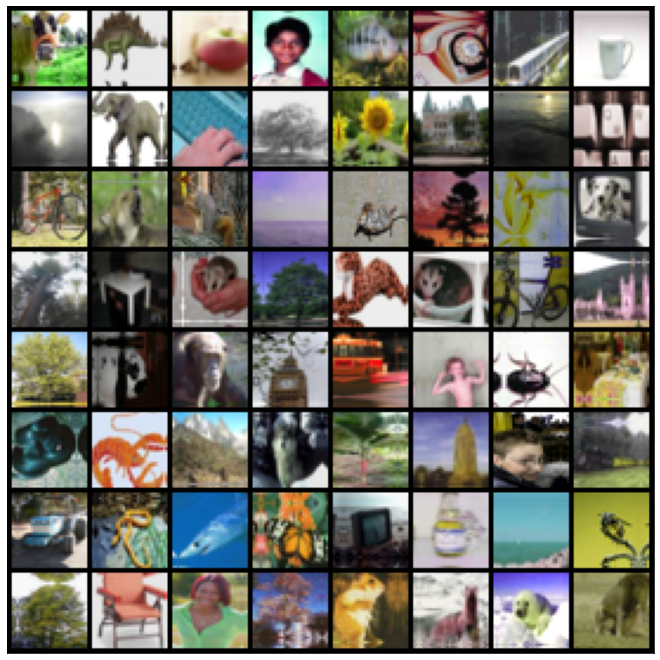

In [4]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_loader)

In [5]:
## RESNET CODE ADAPTED FROM 
## https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/resnet.py

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(in_channels)
        self.depthwise_relu = nn.ReLU(inplace=True)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
                    DepthwiseSeparableConv(in_channels, out_channels, stride=stride),
                    DepthwiseSeparableConv(out_channels, out_channels * BasicBlock.expansion)
                )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=100):
        super().__init__()
        self.in_channels = 32

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        self.conv2_x = self._make_layer(block, 32, num_block[0], 1)  
        self.conv3_x = self._make_layer(block, 64, num_block[1], 2) 
        self.conv4_x = self._make_layer(block, 96, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 128, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

model = ResNet(BasicBlock, [1, 1, 1, 1], num_classes=100).to(device)
# print the number of parameters - this should be included in your report
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(model.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(model.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

> Number of parameters 94372


steps: 10000.00, train loss: 1.192, train acc: 0.655±0.026, test acc: 0.577±0.023


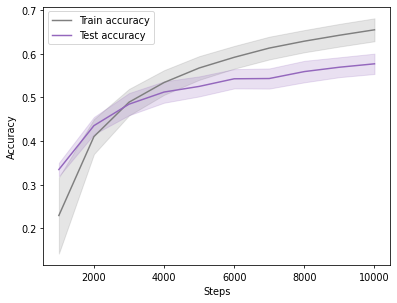

In [6]:
# keep within our optimisation step budget
# initialise the optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
plot_data = []
steps = 0


while (steps < 10000):
    model.train()  # Switch to training mode
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)

    # Iterate through some of the train dataset
    for i in range(1000):
        x, t = next(train_iterator)
        x, t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = model(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()
        steps += 1

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    model.eval()  # Switch to evaluation mode
    test_acc_arr = np.zeros(0)
    with torch.no_grad():  # Deactivate autograd to improve computation efficiency
        # Iterate over the entire test dataset
        for x, t in test_loader:
            x, t = x.to(device), t.to(device)
            p = model(x)
            pred = p.argmax(dim=1, keepdim=True)
            test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # Print your loss and accuracy data - include this in the final report
    print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(
        steps, train_loss_arr.mean(), train_acc_arr.mean(), train_acc_arr.std(), test_acc_arr.mean(), test_acc_arr.std()))

    # Plot your accuracy graph - add a graph like this in your final report
    plot_data.append([steps, np.array(train_acc_arr).mean(), np.array(train_acc_arr).std(), np.array(test_acc_arr).mean(), np.array(test_acc_arr).std()])
    plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
    plt.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.show()
    disp.clear_output(wait=True)